In [11]:
import pandas as pd
import numpy as np
import NDCG as ndcg
import MHR as mhr
import sys
import types
ndcg.reload_package(mhr)
from sklearn.svm import SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from time import time
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
%matplotlib inline

loading MHR


In [12]:
def pr_hs(r): 
    try:
        return ( 1 / r['pageRank'] ) + ( 1 / r['hits'] )
    except:
        return 0

def pr_len(r): 
    try:
        return ( 1 / r['pageRank'] ) + ( 1 / r['word_count'] )
    except:
        return 0
    
def hs_len(r): 
    try:
        return ( 1 / r['hits'] ) + ( 1 / r['word_count'] )
    except:
        return 0

def pr_hs_len(r): 
    try:
        return ( 1 / r['pr_hs'] ) + ( 1 / r['hs_len'] )
    except:
        return 0

def word_count(r): 
    try:
        return len(tokenizer.tokenize(r["reviewText"]))
    except:
        return 0

In [13]:
reviews_features = pd.read_csv('data/book_eletronic_sample_counts.csv.gz')
reviews_features = reviews_features[reviews_features.pageRank>0]
print (reviews_features.shape)
df_columns = reviews_features.select_dtypes(include=['float64','int','int64']).columns
df_columns

(24234, 32)


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,8,10,11,12,13,14,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1',
       'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'overall',
       'unixReviewTime', 'helpfulness', 'tot', 'pageRank', 'hits',
       'powerWithStar', 'word_count', 'pr_hs', 'pr_len', 'hs_len', 'pr_hs_len',
       'sentence_count', 'unigram_count', 'adj', 'noun', 'revRank'],
      dtype='object')

In [14]:
reviews_features['word_count']=reviews_features.apply(word_count,axis=1)
reviews_features['pr_hs']=reviews_features.apply(pr_hs,axis=1)
reviews_features['pr_len']=reviews_features.apply(pr_len,axis=1)
reviews_features['hs_len']=reviews_features.apply(hs_len,axis=1)
reviews_features['pr_hs_len']=reviews_features.apply(pr_hs_len,axis=1)
#reviews_features.to_csv('data/book_sample.csv.gz', compression='gzip')
reviews_features.shape

(24234, 32)

In [15]:
def helpf(x):
    x = str(x['helpful']) 
    try:
        pos = x.replace("[","").replace("]","").split(',')[0]
        neg = x.replace("[","").replace("]","").split(',')[1]
        tot = x.replace("[","").replace("]","").split(',')[1]
        return float ( float(pos) /  float(tot) )
    except:
        return 0

def tot(x): 
    x = str(x['helpful'])
    #print x.replace("[","").replace("]","").split(',')[1]
    try:
        return int(x.replace("[","").replace("]","").split(', ')[1])
    except:
        return 0



reviews_features['helpfulness']=reviews_features.apply(helpf,axis=1)
reviews_features['tot']=reviews_features.apply(tot,axis=1)

In [16]:
#reviews_features,ndcg_mhr = mhr.executeFromDf(reviews_features)

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2496: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


pr_hs ndcg=0.467321115009
pr_len ndcg=0.465769832771
hs_len ndcg=0.469452279099
pr_hs_len ndcg=0.77131406432
PageRank ndcg=0.770294098881
HITs ndcg=0.772097593674
MHR ndcg=0.766695048499
461
461
461
461
461
461
461


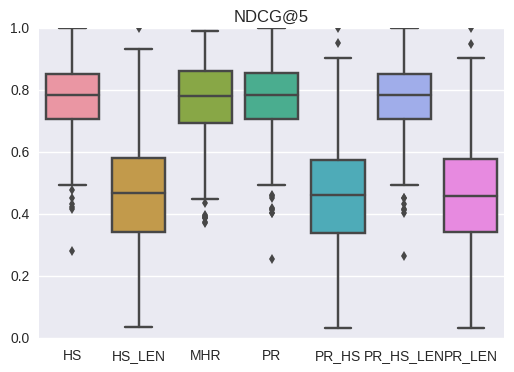

In [17]:
import seaborn as sns
k=5

ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'pr_hs_len',k) 
corr_pr_hs_len=ndcg.calc_corr(reviews_features,'pr_hs_len') 
print ("pr_hs_len ndcg="+str(np.mean(ndcg_pr_hs_len)))

ndcg_mhr=ndcg.calc_ndcg(reviews_features,'powerWithStar',k) 
corr_mhr=ndcg.calc_corr(reviews_features,'powerWithStar') 
print ("MHR ndcg="+str(np.mean(ndcg_mhr)))

ndcg_revRank=ndcg.calc_ndcg(reviews_features,'revRank',k) 
corr_revRank=ndcg.calc_corr(reviews_features,'revRank') 
print ("RevRank ndcg="+str(np.mean(ndcg_revRank)))

print (len(ndcg_pr_hs_len))
print (len(ndcg_mhr))
print (len(ndcg_revRank))

tip={}
tip['PR_HS_LEN']=ndcg_pr_hs_len
tip['MHR']=ndcg_mhr
tip['REVRANK']=ndcg_revRank
df = pd.DataFrame(tip)
ax = sns.boxplot(data=df)
#ax = sns.swarmplot(data=df, color=".25")
ax.set_title('NDCG@'+str(k))

In [18]:
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'pr_hs_len',1) 
print ("pr_hs_len ndcg 1="+str(np.mean(ndcg_pr_hs_len)))
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'pr_hs_len',3) 
print ("pr_hs_len ndcg 3="+str(np.mean(ndcg_pr_hs_len)))
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'pr_hs_len',5) 
print ("pr_hs_len ndcg 5="+str(np.mean(ndcg_pr_hs_len)))

pr_hs_len ndcg 1=0.726896292723
pr_hs_len ndcg 3=0.756294836225
pr_hs_len ndcg 5=0.77131406432


In [22]:
ndcg_revRank=ndcg.calc_ndcg(reviews_features,'revRank',1) 
print ("revRank ndcg 1="+str(np.mean(ndcg_revRank)))
ndcg_revRank=ndcg.calc_ndcg(reviews_features,'revRank',3) 
print ("revRank ndcg 3="+str(np.mean(ndcg_revRank)))
ndcg_revRank=ndcg.calc_ndcg(reviews_features,'revRank',5) 
print ("revRank ndcg 5="+str(np.mean(ndcg_revRank)))

revRank ndcg 1=0.66052590951
revRank ndcg 3=0.681738097775
revRank ndcg 5=0.687225066461


In [20]:
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'powerWithStar',1) 
print ("MHR ndcg 1="+str(np.mean(ndcg_pr_hs_len)))
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'powerWithStar',3) 
print ("MHR ndcg 3="+str(np.mean(ndcg_pr_hs_len)))
ndcg_pr_hs_len=ndcg.calc_ndcg(reviews_features,'powerWithStar',5) 
print ("MHR ndcg 5="+str(np.mean(ndcg_pr_hs_len)))

MHR ndcg 1=0.741230569123
MHR ndcg 3=0.758653152052
MHR ndcg 5=0.766695048499


[None, None, None, None, None, None, None, None, None, None, None, None]

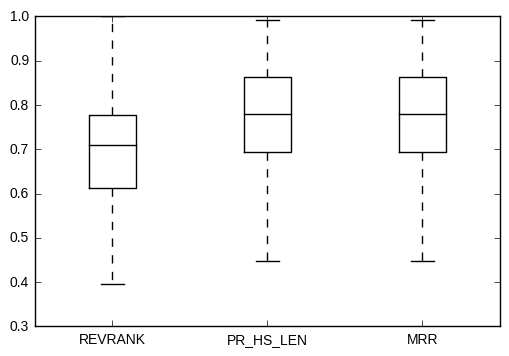

In [24]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt 
%matplotlib inline
data_to_plot = [ndcg_revRank, ndcg_pr_hs_len, ndcg_mhr]


bp = plt.boxplot(data_to_plot, labels=["REVRANK","PR_HS_LEN","MRR"], sym='')
plt.setp(bp['boxes'], linewidth=1, color='black')
plt.setp(bp['fliers'], linewidth=1, color='black')
plt.setp(bp['medians'], linewidth=1, color='black')
plt.setp(bp['whiskers'], linewidth=1, color='black')